In [1]:
from discopy import PRO, Ty
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [3]:
from combinators import lens, sampler, tracing, utils
from combinators.model import collections
import examples.gmm.gmm as gmm

In [4]:
cluster_precisions = torch.from_numpy(np.load('data/gmm/precision.npy'))
cluster_means = torch.from_numpy(np.load('data/gmm/mean.npy'))
zs_ground_truth = torch.from_numpy(np.load('data/gmm/assignment.npy'))
xs = torch.from_numpy(np.load('data/gmm/ob.npy'))

In [5]:
D = xs.shape[2]
K = zs_ground_truth.shape[2]
N = xs.shape[1]
NUM_SAMPLES = xs.shape[0]

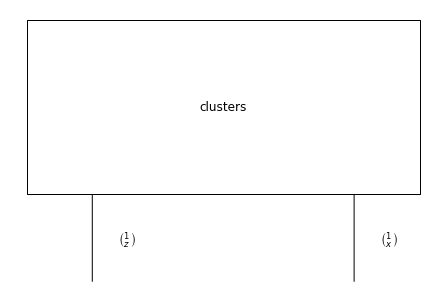

In [6]:
clusters = sampler.ImportanceSampler('clusters', gmm.GaussianClusters(K, D), None, (NUM_SAMPLES,))
clusters_prior = tracing.TracedLensBox('clusters', lens.LensPRO(0), PRO(2) & Ty('z', 'x'), clusters, clusters.update)
clusters_prior.draw()

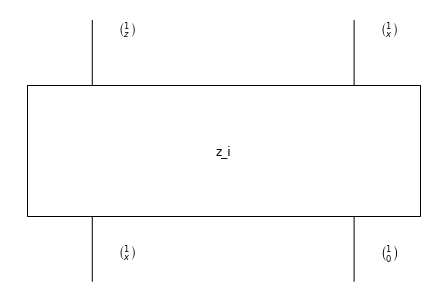

In [7]:
z_sampler = sampler.ImportanceSampler('z_i', gmm.SampleCluster(K, N), None, (NUM_SAMPLES,))
cluster_latent = tracing.TracedLensBox('z_i', PRO(2) & Ty('z', 'x'), PRO(2) & Ty('x'), z_sampler, z_sampler.update)
cluster_latent.draw()

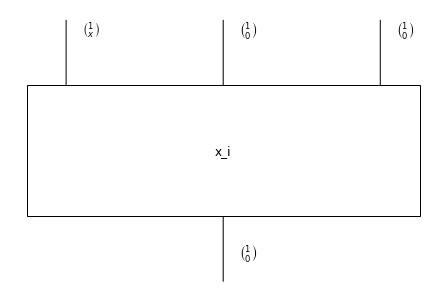

In [8]:
x_sampler = sampler.ImportanceSampler('x_i', gmm.SamplePoint(), None, (NUM_SAMPLES,))
observe_point = tracing.TracedLensBox('x_i', PRO(3) & Ty('x'), PRO(1) & Ty(), x_sampler, x_sampler.update)
observe_point.draw()

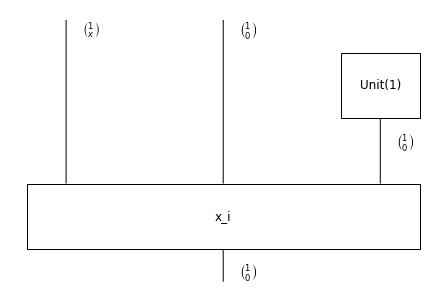

In [9]:
none = lens.Unit(xs, PRO(1) & PRO(0))
likelihood = lens.Id(PRO(2) & Ty('x')) @ none >> observe_point
likelihood.draw()

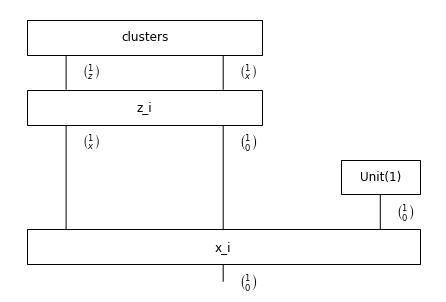

In [10]:
model = clusters_prior >> cluster_latent >> likelihood
model.draw()

In [11]:
FIGSIZE = 6
COLORS = ['#AA3377', '#EE7733', '#0077BB', '#009988', '#555555', '#999933']

def viz_data(xs, zs, means, precisions, bound=40):
    fig, ax = plt.subplots(figsize=(FIGSIZE, FIGSIZE))
    for k in range(K):
        cov_k = np.diag(1. / precisions[k].numpy())
        xs_k = xs[zs == k].numpy()
        ax.scatter(xs_k[:, 0], xs_k[:, 1], c=COLORS[k], zorder=3)
        utils.plot_cov_ellipse(cov=cov_k, pos=means[k], nstd=2, color=COLORS[k], ax=ax, alpha=0.3, zorder=3)
    
    ax.set_ylim([-bound, bound])
    ax.set_xlim([-bound, bound])
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    plt.close()

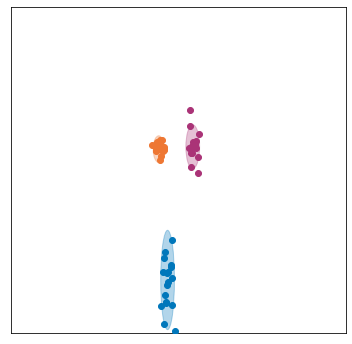

In [12]:
viz_data(xs[0], zs_ground_truth[0].argmax(dim=-1), cluster_means[0], cluster_precisions[0])

In [13]:
graph = model.compile()
_ = model.trace(graph)

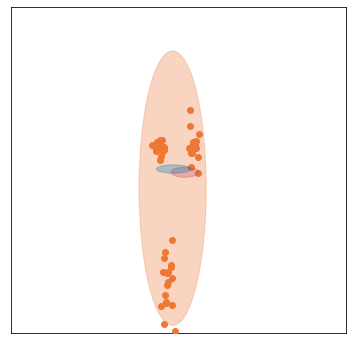

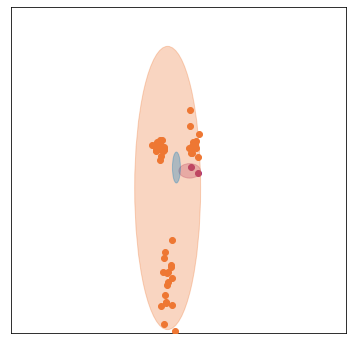

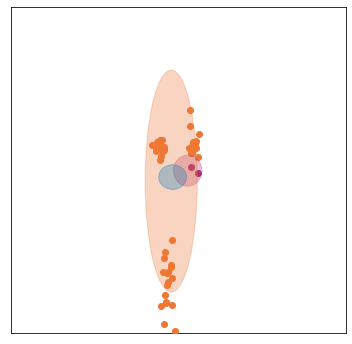

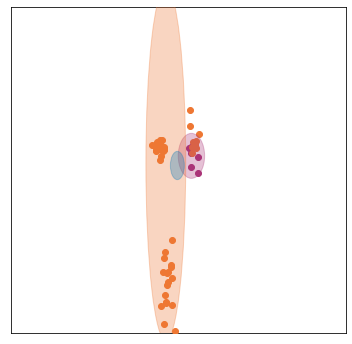

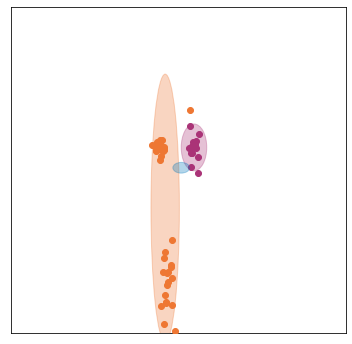

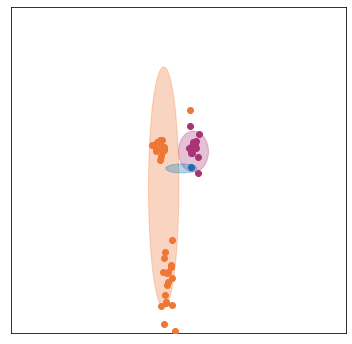

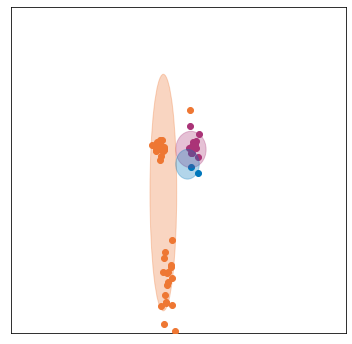

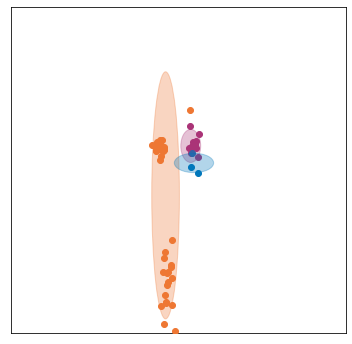

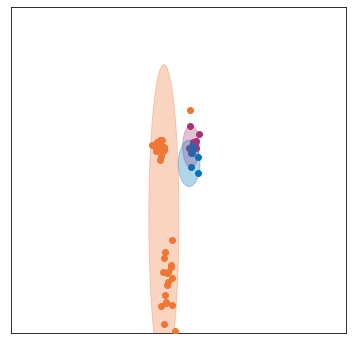

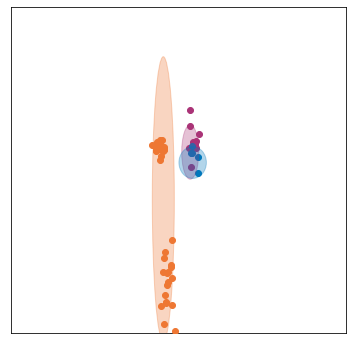

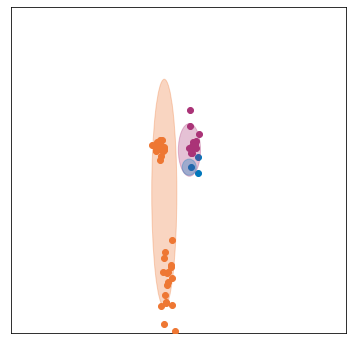

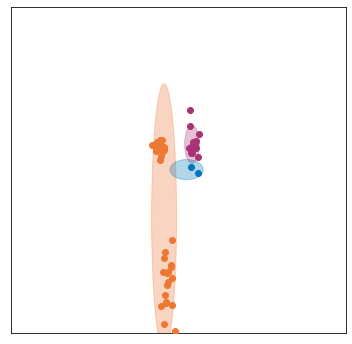

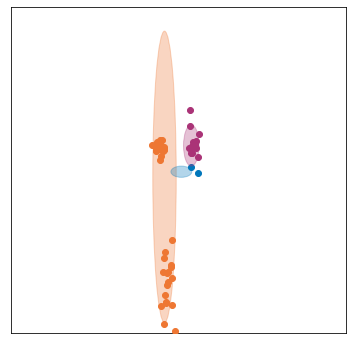

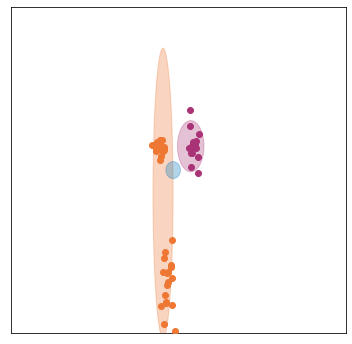

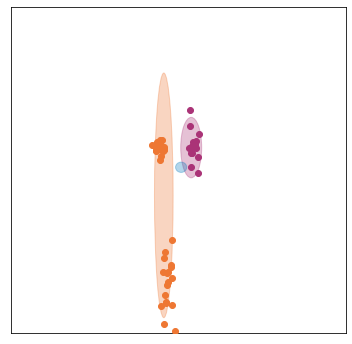

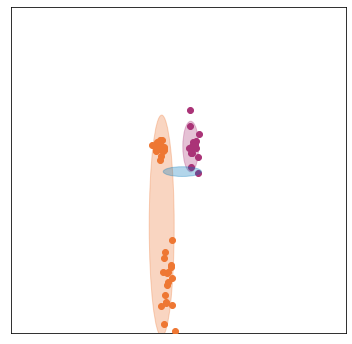

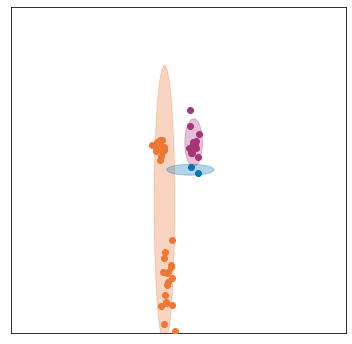

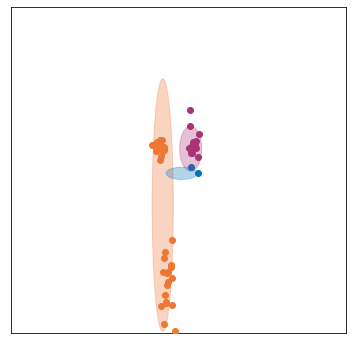

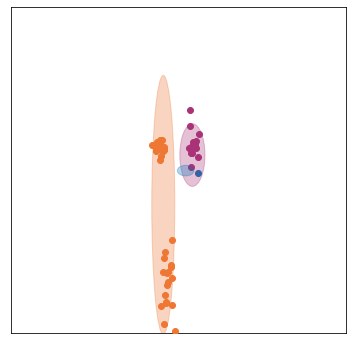

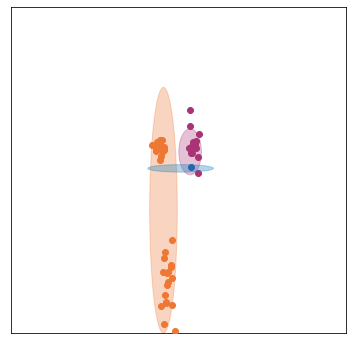

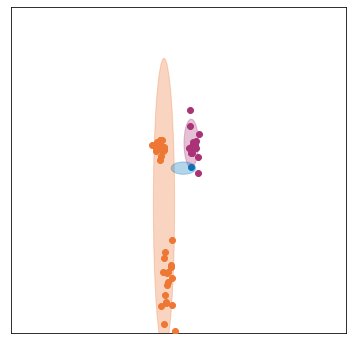

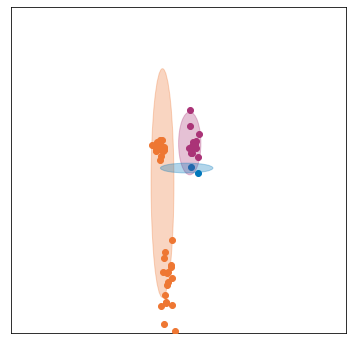

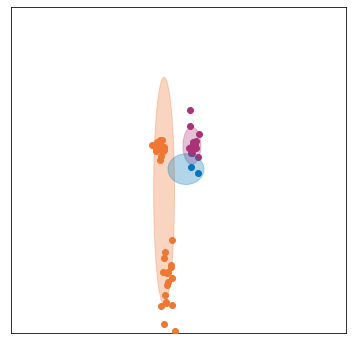

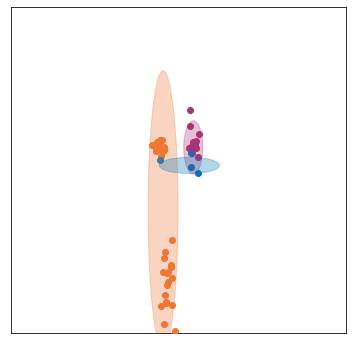

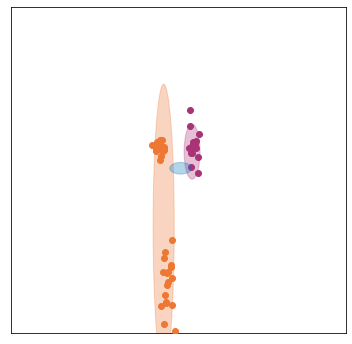

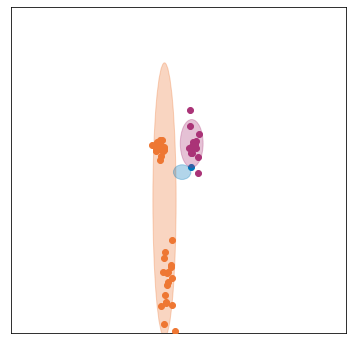

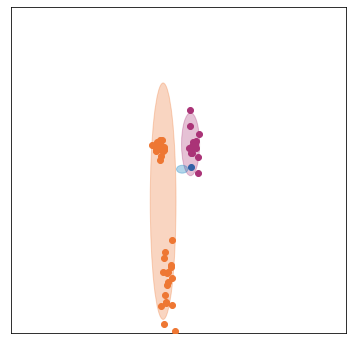

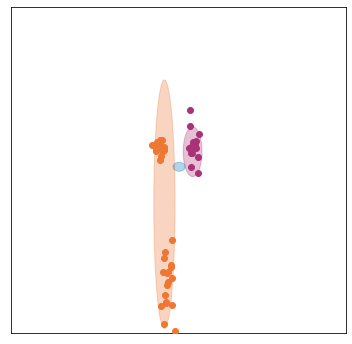

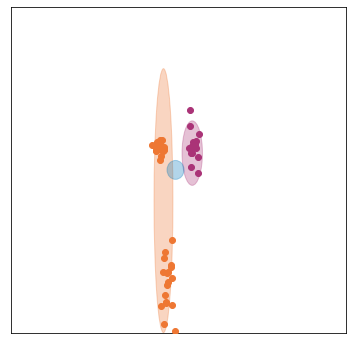

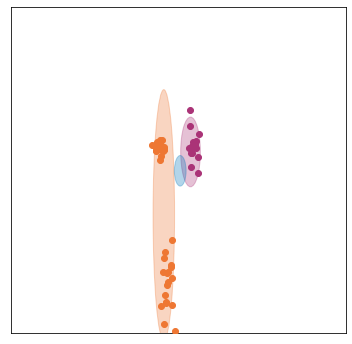

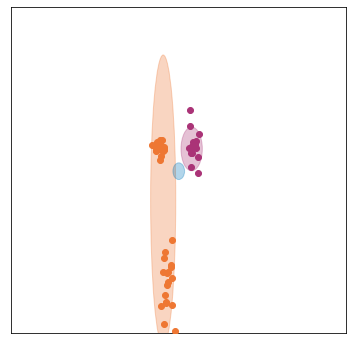

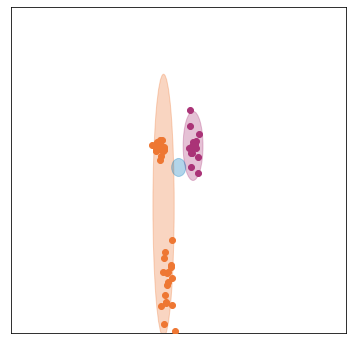

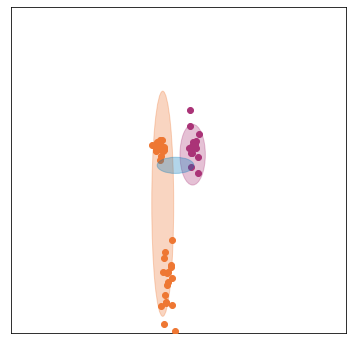

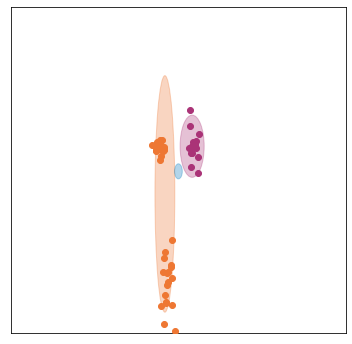

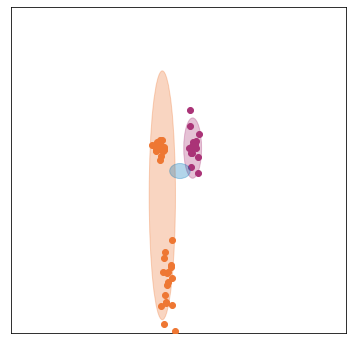

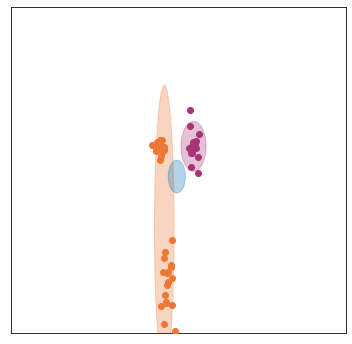

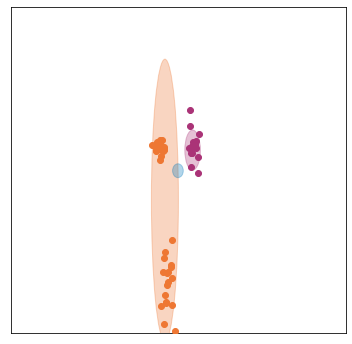

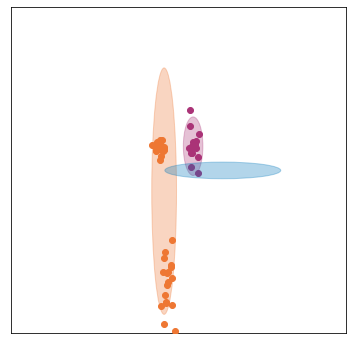

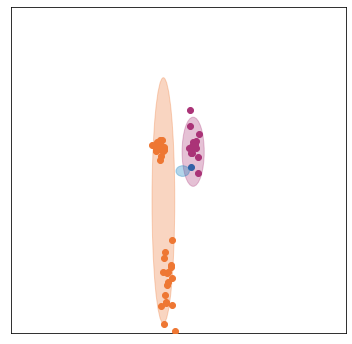

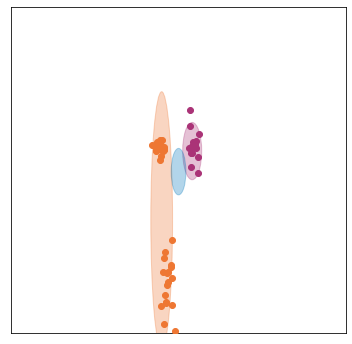

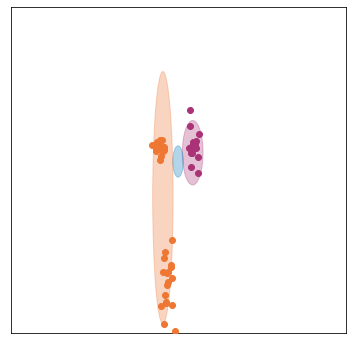

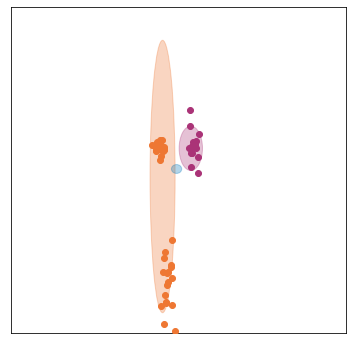

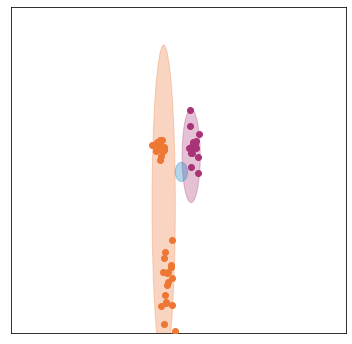

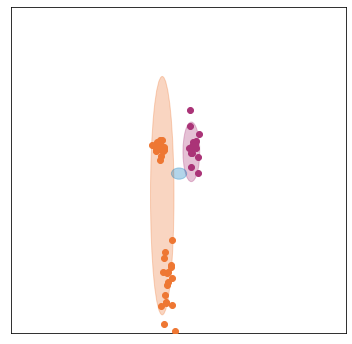

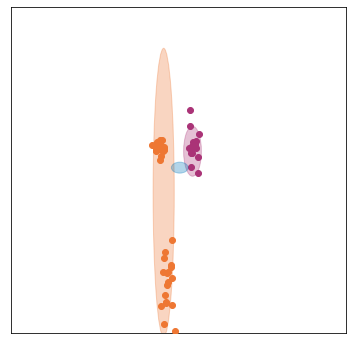

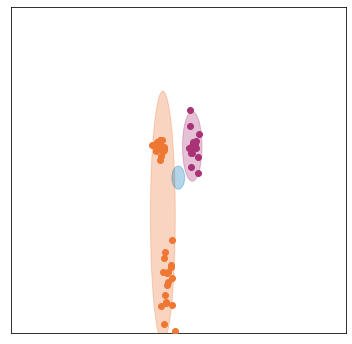

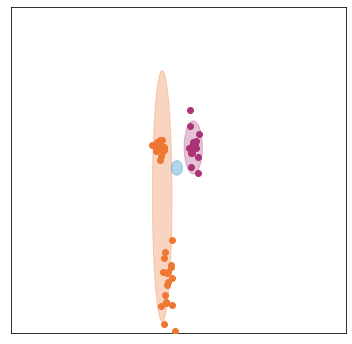

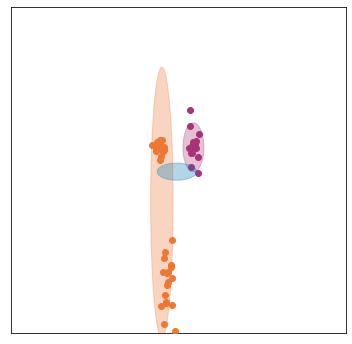

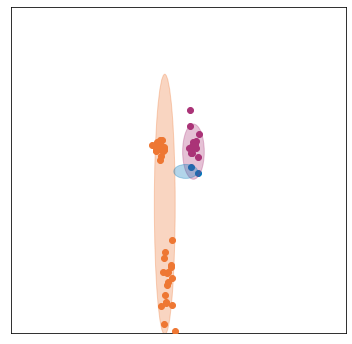

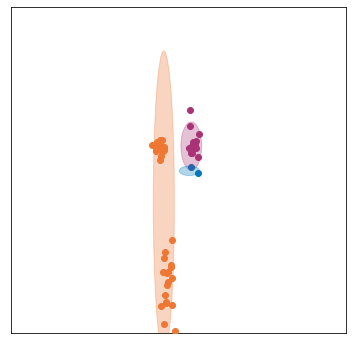

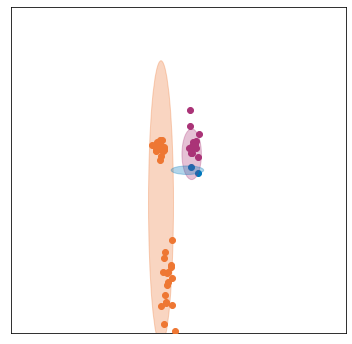

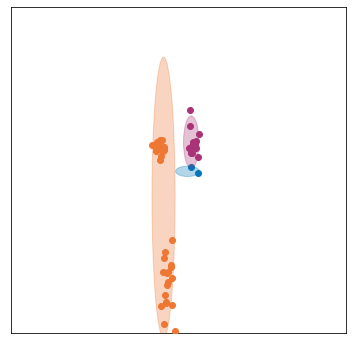

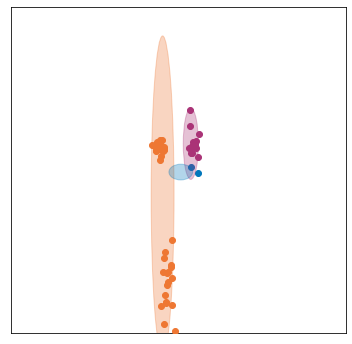

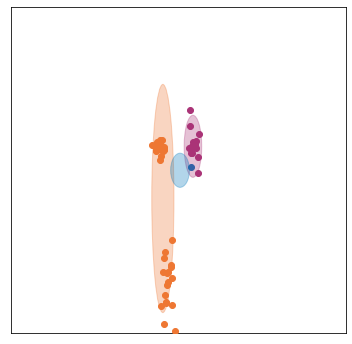

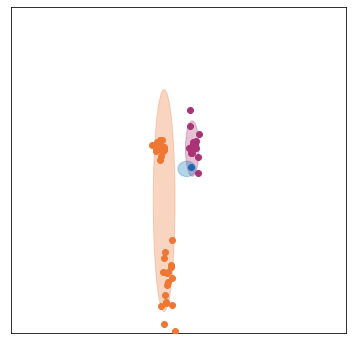

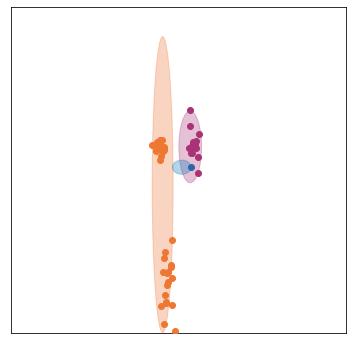

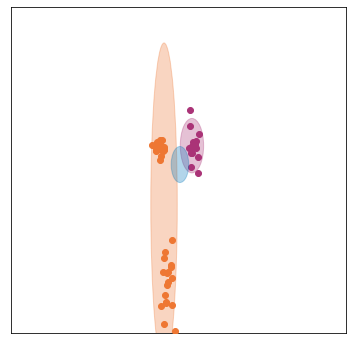

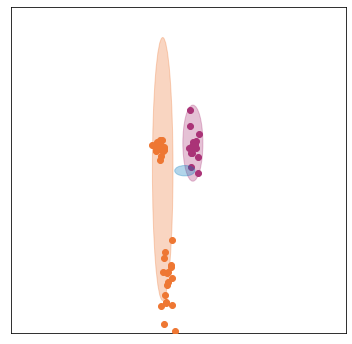

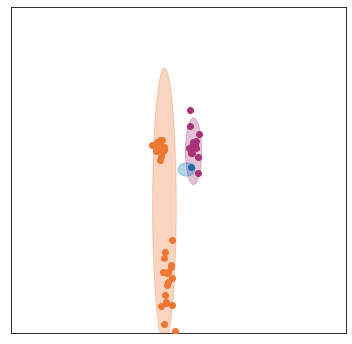

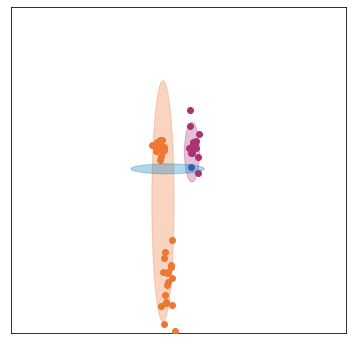

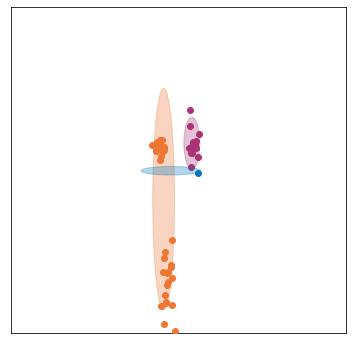

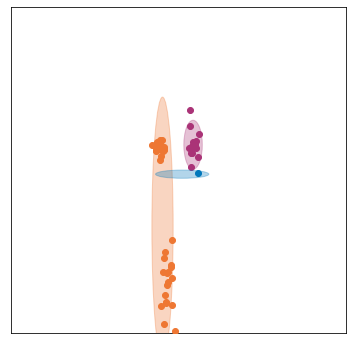

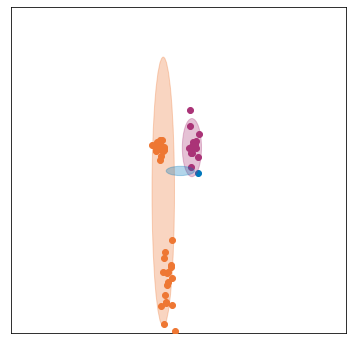

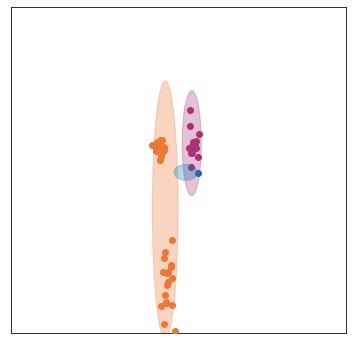

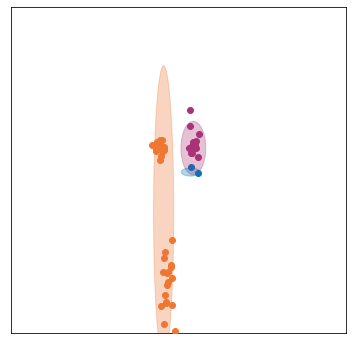

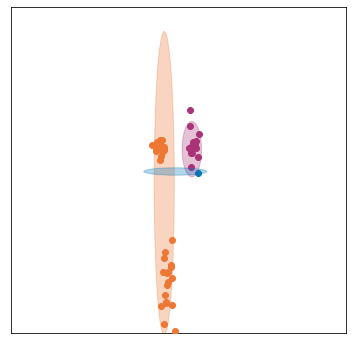

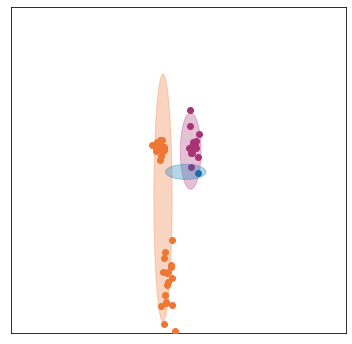

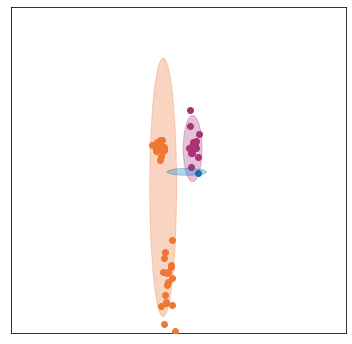

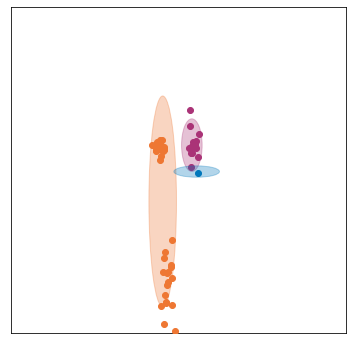

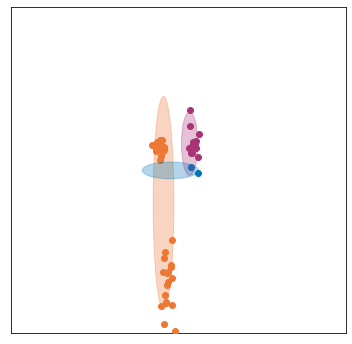

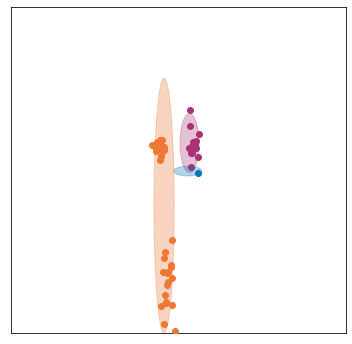

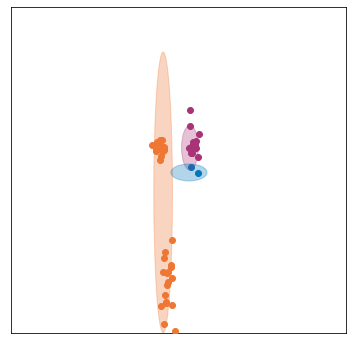

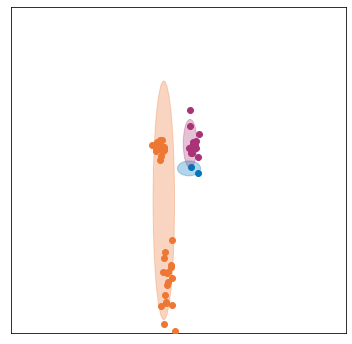

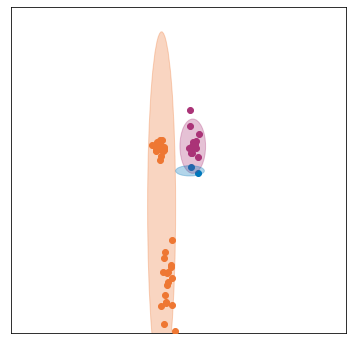

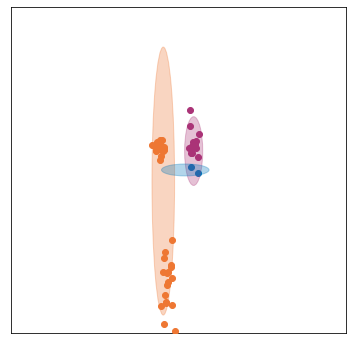

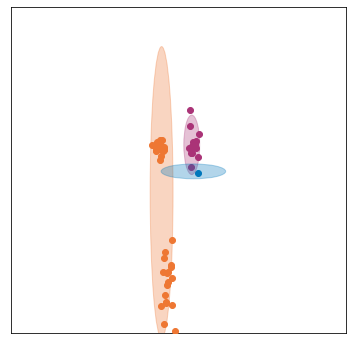

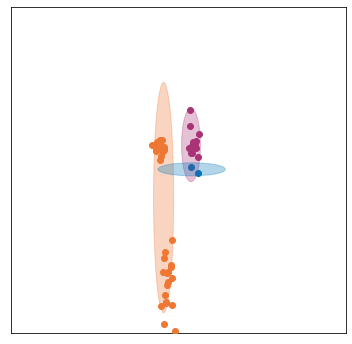

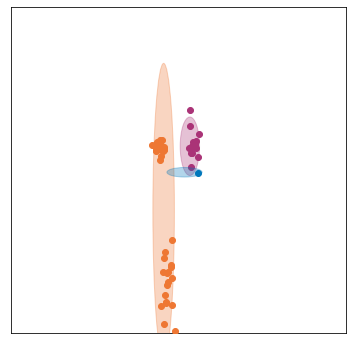

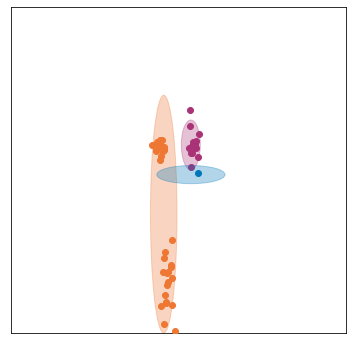

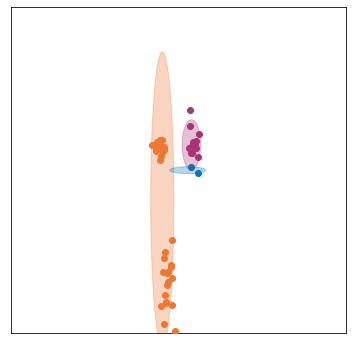

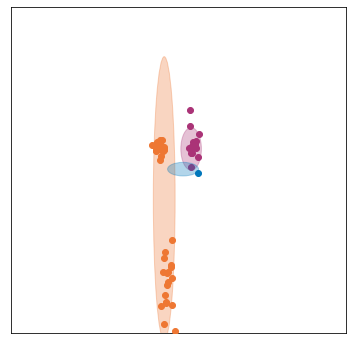

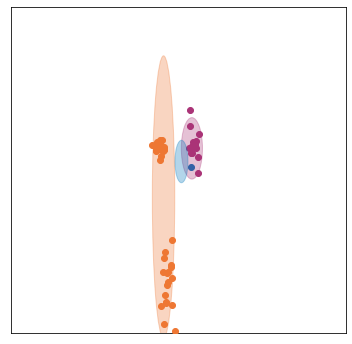

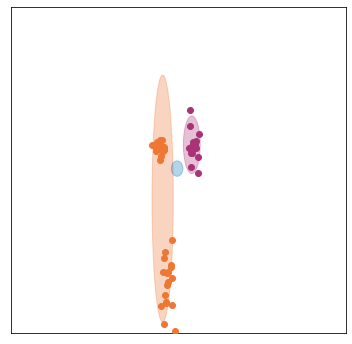

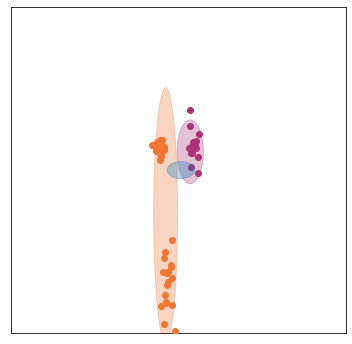

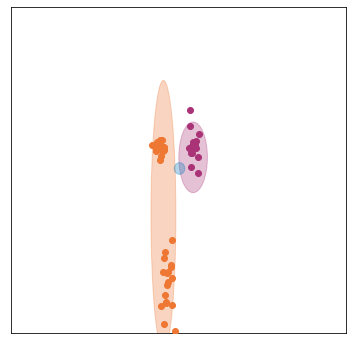

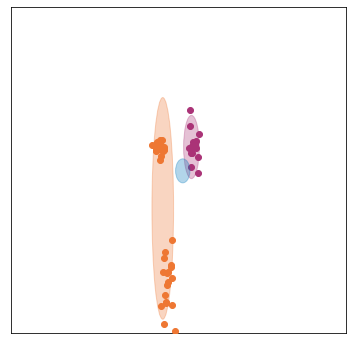

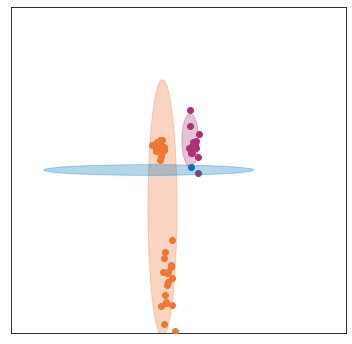

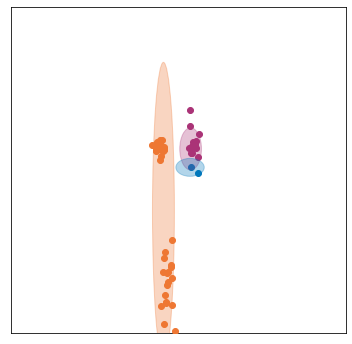

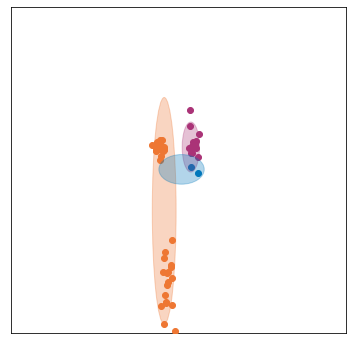

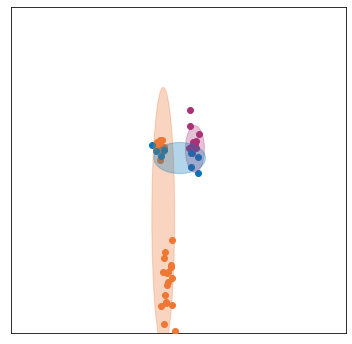

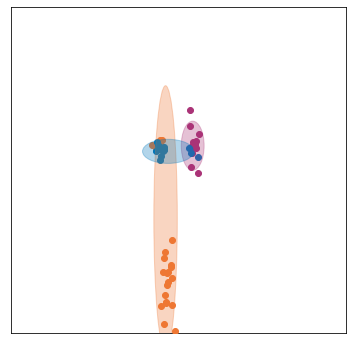

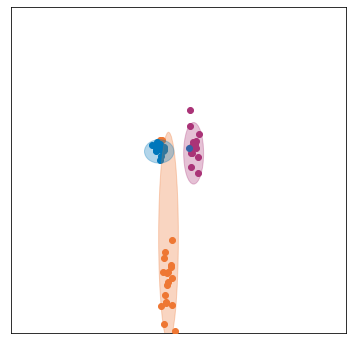

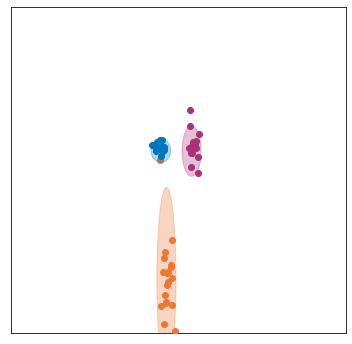

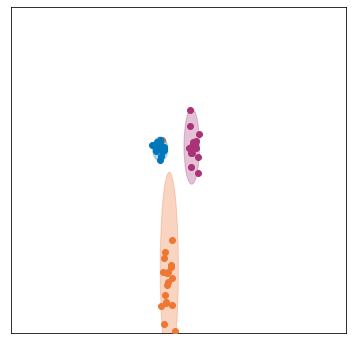

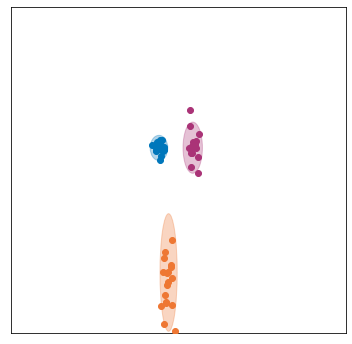

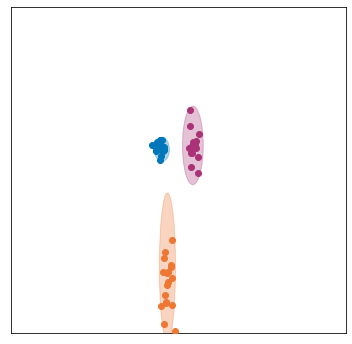

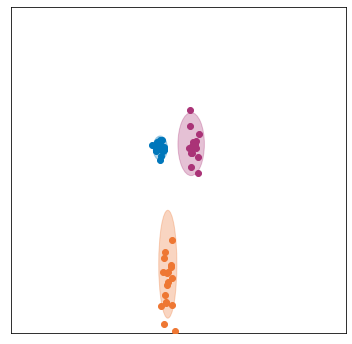

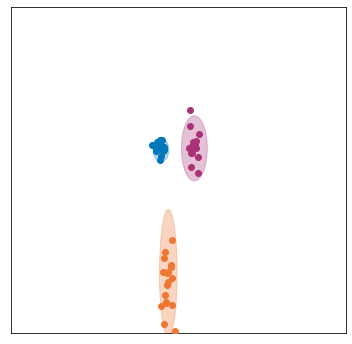

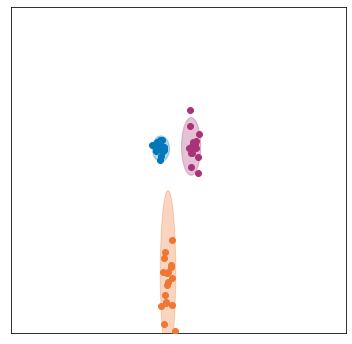

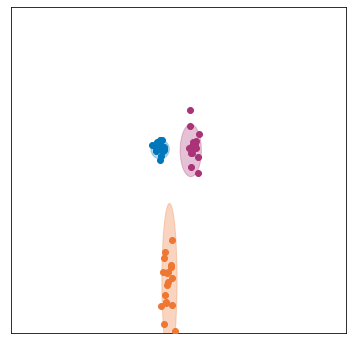

In [14]:
for _ in range(100):
    graph.update()
    xs_sampled, trace = model.trace(graph)

    p = trace.fold()[1]
    estimated_means = p['mu'].value[0]
    estimated_precisions = p['tau'].value[0]
    estimated_zs = p['z'].value[0]
    
    viz_data(xs[0], estimated_zs, estimated_means, estimated_precisions)